In [58]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Packages

In [59]:
from uacqr import uacqr
from helper import generate_data

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

# Define Data Generating Process (for simulated settings)

In a conditional gaussian setting, set the conditional expectation and the conditional noise

In [61]:
def cond_exp(x):
    return (x[:,0]>-0)*1 # Generally we only make function of first covariate
def noise_sd_fn(x):
    return 0.01 + np.sin(15*x[:,0])**2*(x[:,0]>0) # Like above, only function of first covariate 

In [62]:
x_dist = partial(np.random.uniform, low=-1, high=1)

In [63]:
n=200
T=200 # number of test points
p=100
n0 = int(n/2) # number of training points

# Simulate Data

In [64]:
np.random.seed(3)
data = generate_data(n+T, p, cond_exp, noise_sd_fn, x_dist)

In [65]:
x = data[0]
y = data[1]

if len(x.shape)==1:
    x = x.reshape(-1,1)

x_train = x[:n0]
y_train = y[:n0]

x_calib = x[n0:n]
y_calib = y[n0:n]

x_test = x[n:]
y_test = y[n:]

Text(0.5, 1.0, 'Y versus X')

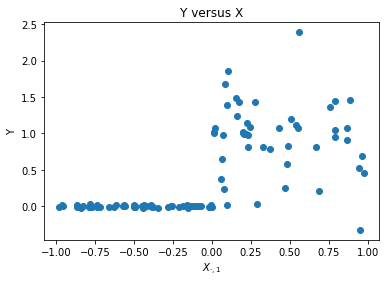

In [66]:
plt.scatter(x_train[:,0], y_train)
plt.xlabel('$X_{\cdot,1}$')
plt.ylabel('Y')
plt.title('Y versus X')

# Run UACQR

Define model hyperparameters

In [67]:
params_qforest = dict()
params_qforest["min_samples_leaf"] = 5
params_qforest["max_features"] = 1.

Initialize uacqr class.

In [68]:
%%time
uacqr_results = uacqr(params_qforest,
                     model_type='rfqr',B=100, random_state=0, uacqrs_agg='iqr')

CPU times: user 33 µs, sys: 12 µs, total: 45 µs
Wall time: 50.3 µs


Fit the base quantile regressors

In [69]:
uacqr_results.fit(x_train, y_train)

Conformalize / calibrate the quantile regressors

In [70]:
uacqr_results.calibrate(x_calib, y_calib)

# Evaluation

Evaluate the various conformal methods on test data

In [71]:
uacqr_results.evaluate(x_test, y_test)

{'interval_score_loss': {'UACQR-P': 1.4720500658122109,
  'UACQR-S': 1.5232398128898346,
  'CQR': 1.6197137779867585,
  'CQR-r': 1.4001101174664785,
  'Base': 1.4672919748498652},
 'test_coverage': {'UACQR-P': 0.96,
  'UACQR-S': 0.94,
  'CQR': 0.96,
  'CQR-r': 0.945,
  'Base': 0.875},
 'average_length_test': {'UACQR-P': 1.31520273907925,
  'UACQR-S': 1.2816158885365854,
  'CQR': 1.415328,
  'CQR-r': 1.1786069,
  'Base': 0.9013936}}

# Plot Results (for simulated data)

All in one chart

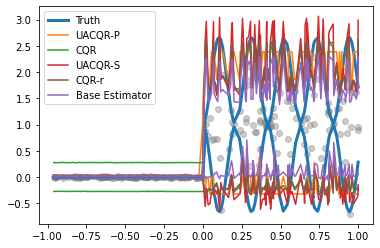

In [72]:
uacqr_results.plot(cond_exp, noise_sd_fn)

Graphic with simpler formatting

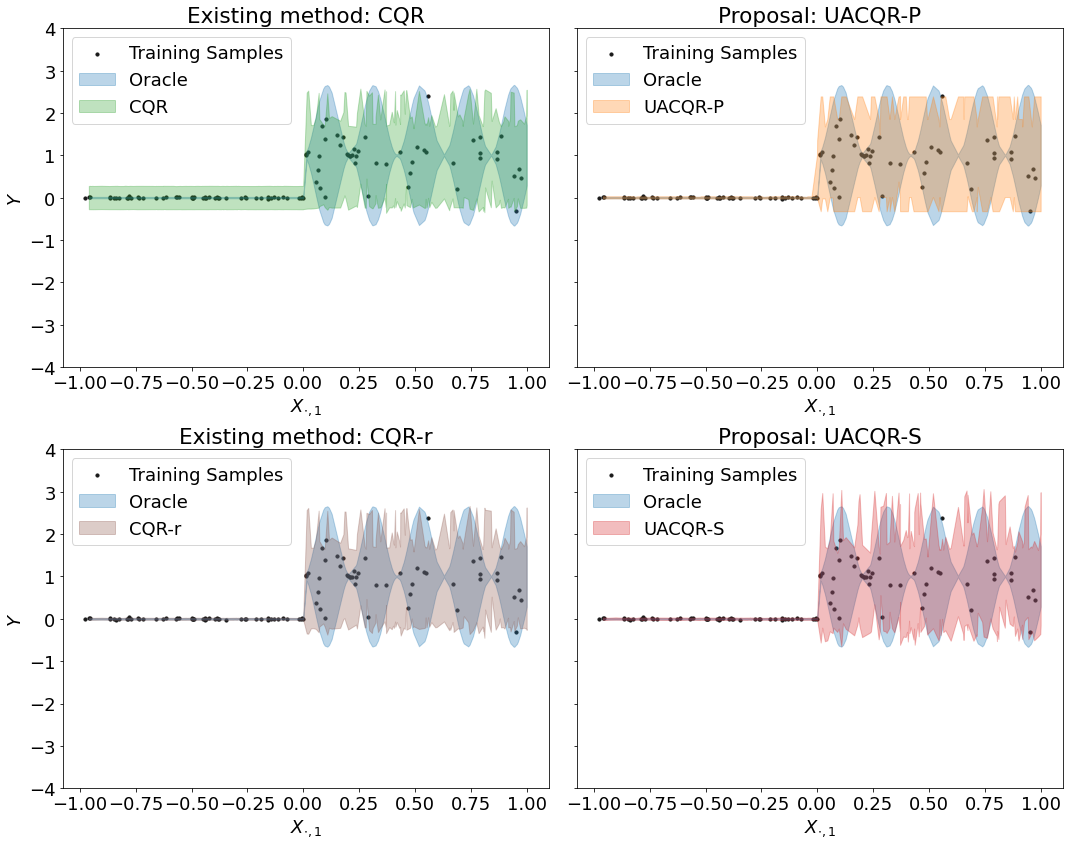

In [75]:
uacqr_results.plot_simple(cond_exp, noise_sd_fn,
                         xlabel='$X_{\cdot,1}$', expanded=True)
plt.tight_layout()